<a href="https://colab.research.google.com/github/Buitragox/Crowdsourcing-Thesis/blob/main/notebooks/gold.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Gold Standard Training

Base model with gold standard dataset

Two models are trained
- Categorical crossentropy
- Focal loss

Dataset with oversampling was not used.

Dataset before feature extraction: https://drive.google.com/drive/folders/1yWT1aaQLiZAkAomtAdFlqlVWnRkhNrCu

The images are located in three separate folders: 1, 2 and 3. This indicates the image's class.

The labels were encoded using one-hot.

In [ ]:
import numpy as np
import pandas as pd
import zipfile

from matplotlib import pyplot as plt

from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout

In [ ]:
# If using google drive in google colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Files with commonly used functions and utilities
!wget --no-check-certificate 'https://raw.githubusercontent.com/Buitragox/Crowdsourcing-Thesis/main/utils.py' -O utils.py
!wget --no-check-certificate 'https://raw.githubusercontent.com/Buitragox/Crowdsourcing-Thesis/main/grid_search.py' -O grid_search.py

--2024-05-29 00:58:10--  https://raw.githubusercontent.com/Buitragox/Crowdsourcing-Thesis/main/BCSS/utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5405 (5.3K) [text/plain]
Saving to: ‘utils.py’

utils.py            100%[===================>]   5.28K  --.-KB/s    in 0s      

2024-05-29 00:58:10 (40.2 MB/s) - ‘utils.py’ saved [5405/5405]

--2024-05-29 00:58:10--  https://raw.githubusercontent.com/Buitragox/Crowdsourcing-Thesis/main/BCSS/grid_search.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5486 (5.4K) [text/plain

In [ ]:
from utils import load_gold_data
from grid_search import grid_search, show_results, save_to_json

In [ ]:
# pkl file with crowdsourced labels
!wget --no-check-certificate 'https://github.com/Buitragox/Crowdsourcing-Thesis/raw/main/data/pkl/train_crowdsourced_labels.pkl' -O train_crowdsourced_labels.pkl

--2024-05-29 00:58:11--  https://github.com/Buitragox/Crowdsourcing-Thesis/raw/main/BCSS/pkl/train_crowdsourced_labels.pkl
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Buitragox/Crowdsourcing-Thesis/main/BCSS/pkl/train_crowdsourced_labels.pkl [following]
--2024-05-29 00:58:11--  https://raw.githubusercontent.com/Buitragox/Crowdsourcing-Thesis/main/BCSS/pkl/train_crowdsourced_labels.pkl
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10426477 (9.9M) [application/octet-stream]
Saving to: ‘train_crowdsourced_labels.pkl’

train_crowdsourced_ 100%[===================>]   9.94M  --.-KB/s    in 0.1s

In [ ]:
# Download TrainTestNpyInt.zip from google drive
!pip install gdown
!gdown 1XeVC0FOmv_V8jY31JP73yXqa4q27EWJS -O TrainTestNpyInt.zip

Downloading...
From (original): https://drive.google.com/uc?id=1XeVC0FOmv_V8jY31JP73yXqa4q27EWJS
From (redirected): https://drive.google.com/uc?id=1XeVC0FOmv_V8jY31JP73yXqa4q27EWJS&confirm=t&uuid=802eaef8-902d-42e4-b96f-7b4cfa021847
To: /content/TrainTestNpyInt.zip
100% 96.7M/96.7M [00:02<00:00, 44.5MB/s]


In [ ]:
# Extract zip file
with zipfile.ZipFile("./TrainTestNpyInt.zip", 'r') as zip_ref:
    zip_ref.extractall("./TrainTestNpyInt")

In [ ]:
pkl_path = "./train_crowdsourced_labels.pkl"

# Path for the extracted zip files
data_path = "./TrainTestNpyInt"

# Path to save the results
json_path = "./drive/MyDrive/Experiment results/gold"
K = 3

In [ ]:
def build_model():
    """Base arquitecture for training all models"""
    input_layer = Input(shape=(512, ))

    model = Dense(128, activation='relu')(input_layer)
    model = Dropout(0.25)(model)
    model = Dense(64, activation='relu')(model)
    model = Dropout(0.25)(model)

    model = Dense(K, activation="softmax")(model)

    model = Model(input_layer, model, name="VGG16_GOLD")

    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
    return model

build_model().summary()

Model: "VGG16_GOLD"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 512)]             0         
                                                                 
 dense_2 (Dense)             (None, 128)               65664     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 64)                8256      
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_4 (Dense)             (None, 3)                 195       
                                                                 
Total params: 74115 (289.51 KB)
Trainable params: 74115 

In [ ]:
def evaluate(model, X_test, Y_test):
    y_pred = model.predict(X_test)
    y_pred = np.argmax(y_pred, axis=1)
    report = classification_report(np.argmax(Y_test, axis=1), y_pred, output_dict=True)
    return report

In [ ]:
X_train, labels, X_test, Y_test = load_gold_data(data_path, pkl_path)

history, report = grid_search(X_train, labels, X_test, Y_test, build_model, evaluate, repeat=2, epochs=10, validation_split=0.2)

Run #1
Epoch 1/10
7525/7525 [==============================] - 35s 4ms/step - loss: 0.4848 - accuracy: 0.8113 - val_loss: 0.3932 - val_accuracy: 0.8429
Epoch 2/10
7525/7525 [==============================] - 30s 4ms/step - loss: 0.4070 - accuracy: 0.8404 - val_loss: 0.3809 - val_accuracy: 0.8527
Epoch 3/10
7525/7525 [==============================] - 29s 4ms/step - loss: 0.3905 - accuracy: 0.8468 - val_loss: 0.3537 - val_accuracy: 0.8586
Epoch 4/10
7525/7525 [==============================] - 29s 4ms/step - loss: 0.3752 - accuracy: 0.8503 - val_loss: 0.3504 - val_accuracy: 0.8572
Epoch 5/10
7525/7525 [==============================] - 29s 4ms/step - loss: 0.3688 - accuracy: 0.8543 - val_loss: 0.3449 - val_accuracy: 0.8636
Epoch 6/10
7525/7525 [==============================] - 29s 4ms/step - loss: 0.3602 - accuracy: 0.8576 - val_loss: 0.3449 - val_accuracy: 0.8623
Epoch 7/10
7525/7525 [==============================] - 30s 4ms/step - loss: 0.3558 - accuracy: 0.8580 - val_loss: 0.3558 -

In [ ]:
show_results(history, report, K)

parameters = {}
	mean f1 scores: [0.8686367080715145, 0.7488557017009703, 0.7348605040005178]
	std f1 scores: [0.008380542902330756, 0.0019612917630819626, 0.0030472575292909143]
	mean accuracy: 0.8203483043079743
	std accuracy: 0.007103574702108206


In [ ]:
save_to_json(history, report, json_path+'/history_gold_int.json', json_path+'/report_gold_int.json')

In [ ]:
rep = report[0]["reports"][0]
print(rep)

{'0': {'precision': 0.8758799555390886, 'recall': 0.8781575037147102, 'f1-score': 0.8770172509738453, 'support': 2692}, '1': {'precision': 0.7340255591054313, 'recall': 0.7683946488294314, 'f1-score': 0.7508169934640523, 'support': 1196}, '2': {'precision': 0.7941888619854721, 'recall': 0.6890756302521008, 'f1-score': 0.7379077615298087, 'support': 476}, 'accuracy': 0.8274518790100825, 'macro avg': {'precision': 0.8013647922099972, 'recall': 0.7785425942654142, 'f1-score': 0.7885806686559022, 'support': 4364}, 'weighted avg': {'precision': 0.8280928751847862, 'recall': 0.8274518790100825, 'f1-score': 0.8272574835684663, 'support': 4364}}


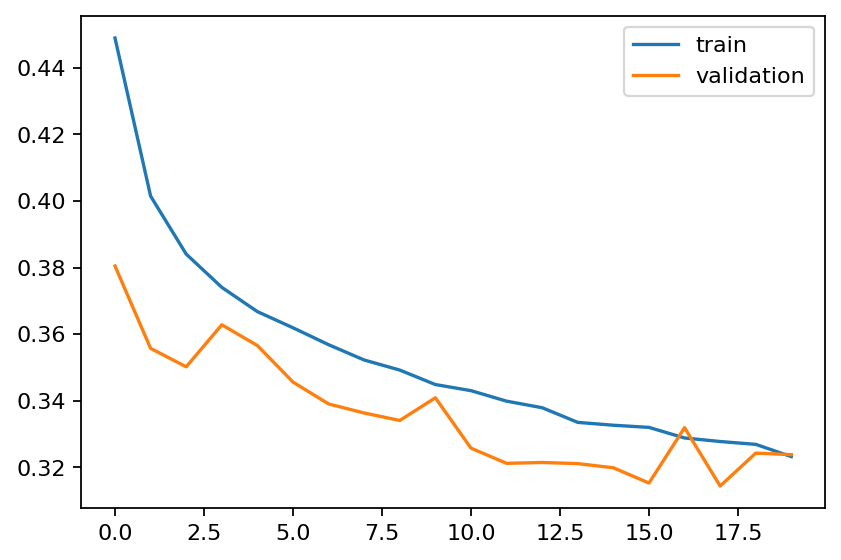

In [ ]:
run = history[0]["histories"][0]
plt.figure(figsize=(6, 4), dpi=160)
plt.plot(run["loss"], label="train")
plt.plot(run["val_loss"], label="validation")
plt.legend()
plt.show()

## Over Sampling

NOTE: Oversampling was not used in final analisis.

In [ ]:
from imblearn.over_sampling import RandomOverSampler

In [ ]:
X_train, labels, X_test, Y_test = load_gold_data(data_path, pkl_path)

over_sampler = RandomOverSampler(random_state=42)
X_train_os, labels_os = over_sampler.fit_resample(X_train, labels)

In [ ]:
history, report = grid_search(X_train_os, labels_os, X_test, Y_test, build_model, evaluate, repeat=10, epochs=20, validation_split=0.2)

Run #1
Epoch 1/20
11178/11178 [==============================] - 37s 3ms/step - loss: 0.4705 - accuracy: 0.8134 - val_loss: 0.5311 - val_accuracy: 0.7582
Epoch 2/20
11178/11178 [==============================] - 38s 3ms/step - loss: 0.4097 - accuracy: 0.8360 - val_loss: 0.5724 - val_accuracy: 0.7536
Epoch 3/20
11178/11178 [==============================] - 39s 4ms/step - loss: 0.3927 - accuracy: 0.8427 - val_loss: 0.5839 - val_accuracy: 0.7216
Epoch 4/20
11178/11178 [==============================] - 39s 3ms/step - loss: 0.3815 - accuracy: 0.8470 - val_loss: 0.5166 - val_accuracy: 0.7695
Epoch 5/20
11178/11178 [==============================] - 38s 3ms/step - loss: 0.3728 - accuracy: 0.8522 - val_loss: 0.4435 - val_accuracy: 0.8223
Epoch 6/20
11178/11178 [==============================] - 36s 3ms/step - loss: 0.3648 - accuracy: 0.8548 - val_loss: 0.5062 - val_accuracy: 0.7496
Epoch 7/20
11178/11178 [==============================] - 38s 3ms/step - loss: 0.3585 - accuracy: 0.8570 - val_

In [ ]:
show_results(history, report, K)

parameters = {}
	mean f1 scores: [0.846533790345185, 0.7210437937828895, 0.7433244411583024]
	std f1 scores: [0.01974246160296447, 0.01936722623622532, 0.009758278023175821]
	mean accuracy: 0.7969752520623281
	std accuracy: 0.019360189952269062


In [ ]:
save_to_json(history, report, json_path+'/history_gold_int_os.json', json_path+'/report_gold_int_os.json')

# Focal Loss

In [ ]:
from tensorflow.keras.losses import Loss

In [ ]:
class FocalLoss(Loss):
    def __init__(self, gamma=2.0, alpha=None, num_classes=None):
        super().__init__()
        self.gamma = gamma
        if num_classes is None:
            raise ValueError("The 'num_classes' parameter must be specified.")
        if alpha is None:
            alpha = [1 for _ in range(num_classes)]
        elif len(alpha) != num_classes:
            raise ValueError("The length of 'alpha' must be equal to 'num_classes'.")
        self.alpha = tf.convert_to_tensor(alpha, dtype=tf.float32)

    def call(self, y_true, y_pred):
        y_pred_clip = tf.clip_by_value(y_pred, clip_value_min=1e-4, clip_value_max=1-1e-4)
        cce = tf.keras.losses.CategoricalCrossentropy(reduction=tf.keras.losses.Reduction.NONE)
        entropy = cce(y_true, y_pred)

        weight = tf.math.pow(1.0 - y_pred_clip, self.gamma)
        focal = tf.reduce_sum(y_true * self.alpha * weight, axis=1)
        loss = focal * entropy

        return tf.reduce_mean(loss)

In [ ]:
# This function receives onehot encoded labels
# Give more importance to classes with less amount of samples in the dataset
def calculate_weights(y):
    y = np.argmax(y, axis=-1) # from onehot to class value (0, 1, 2)
    counts = np.unique(y, return_counts=True)[1]
    weights = 1 / (counts / len(y)) # inverse of the percentaje of labels per class
    sum_weights = np.sum(weights)
    return weights / sum_weights

In [ ]:
def create_build_func(alpha: list[float]):
    def build_focal_loss(gamma=1.0):
        input_layer = Input(shape=(512, ))

        model = Dense(128, activation='relu')(input_layer)
        model = Dropout(0.25)(model)
        model = Dense(64, activation='relu')(model)
        model = Dropout(0.25)(model)

        model = Dense(K, activation="softmax")(model)

        model = Model(input_layer, model, name="VGG16_GOLD_FOCAL_LOSS")

        model.compile(optimizer="adam", loss=FocalLoss(gamma=gamma, alpha=alpha, num_classes=3), metrics=["accuracy"])
        return model

    return build_focal_loss

### Training with alpha

In [ ]:
X_train, labels, X_test, Y_test = load_gold_data(data_path, pkl_path)

In [ ]:
alpha = calculate_weights(labels)
print(alpha)
build_func = create_build_func(alpha)

[2.01940419 2.71949545 7.29452254]
[0.16781628 0.22599518 0.60618853]


In [ ]:
gamma = [1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]
history_path = json_path + '/history_gold_int_focal.json'
report_path = json_path + '/report_gold_int_focal.json'

exp_history, exp_report = grid_search(X_train, labels, X_test, Y_test, build_func,
                                      evaluate, repeat=10, epochs=20, validation_split=0.2,
                                      report_path=report_path, history_path=history_path, gamma=gamma)


Finished experiments: {(2.0,), (2.5,), (5.0,), (4.0,), (4.5,), (1.0,), (1.5,)}
Experiment with parameters: {'gamma': 3.0}
Run #1
Epoch 1/20
7525/7525 [==============================] - 27s 3ms/step - loss: 0.0375 - accuracy: 0.7577 - val_loss: 0.0240 - val_accuracy: 0.8234
Epoch 2/20
7525/7525 [==============================] - 26s 3ms/step - loss: 0.0279 - accuracy: 0.7928 - val_loss: 0.0218 - val_accuracy: 0.8228
Epoch 3/20
7525/7525 [==============================] - 26s 3ms/step - loss: 0.0273 - accuracy: 0.8017 - val_loss: 0.0267 - val_accuracy: 0.8112
Epoch 4/20
7525/7525 [==============================] - 24s 3ms/step - loss: 0.0255 - accuracy: 0.8025 - val_loss: 0.0233 - val_accuracy: 0.7685
Epoch 5/20
7525/7525 [==============================] - 26s 3ms/step - loss: 0.0249 - accuracy: 0.8074 - val_loss: 0.0230 - val_accuracy: 0.8155
Epoch 6/20
7525/7525 [==============================] - 28s 4ms/step - loss: 0.0244 - accuracy: 0.8050 - val_loss: 0.0233 - val_accuracy: 0.7893
E

In [ ]:
show_results(exp_history, exp_report, K)

parameters = {'gamma': 1.0}
	mean f1 scores: [0.8687050171539287, 0.7461580500611925, 0.7147690149264148]
	std f1 scores: [0.008768216238164556, 0.012240333849085568, 0.030743370270033044]
	mean accuracy: 0.8154903758020164
	std accuracy: 0.010204556513752003
parameters = {'gamma': 2.0}
	mean f1 scores: [0.8478464790916937, 0.7178714938254543, 0.6737908918598798]
	std f1 scores: [0.021187273945552646, 0.01928751877349906, 0.02708217540409559]
	mean accuracy: 0.7886113657195235
	std accuracy: 0.019248191369869824
parameters = {'gamma': 2.5}
	mean f1 scores: [0.8640302108211818, 0.7372477901785716, 0.7176033730761016]
	std f1 scores: [0.011349938944466006, 0.017366743272830228, 0.02513559312419964]
	mean accuracy: 0.8105866177818516
	std accuracy: 0.01180018773227053
parameters = {'gamma': 5.0}
	mean f1 scores: [0.8552799546284946, 0.6998408925554538, 0.6840048712326541]
	std f1 scores: [0.012469139072146704, 0.050569540947405324, 0.035753939569851116]
	mean accuracy: 0.7923923006416131


### Training without alpha

In [ ]:
X_train, labels, X_test, Y_test = load_gold_data(data_path, pkl_path)
alpha = [1.0, 1.0, 1.0] # No alpha is the same as multiplying by 1
build_func = create_build_func(alpha)

gamma = [1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]
history_path = json_path + '/history_gold_int_focal_noalpha.json'
report_path = json_path + '/report_gold_int_focal_noalpha.json'

exp_history, exp_report = grid_search(X_train, labels, X_test, Y_test, build_func,
                                      evaluate, repeat=10, epochs=20, validation_split=0.2,
                                      report_path=report_path, history_path=history_path, gamma=gamma)

Finished experiments: {(2.0,), (2.5,), (5.0,), (4.5,), (1.0,), (1.5,), (3.5,), (3.0,)}
Experiment with parameters: {'gamma': 4.0}
Run #1
Epoch 1/20
7525/7525 [==============================] - 23s 3ms/step - loss: 0.0961 - accuracy: 0.7678 - val_loss: 0.0624 - val_accuracy: 0.8203
Epoch 2/20
7525/7525 [==============================] - 24s 3ms/step - loss: 0.0652 - accuracy: 0.8057 - val_loss: 0.0529 - val_accuracy: 0.8254
Epoch 3/20
7525/7525 [==============================] - 24s 3ms/step - loss: 0.0614 - accuracy: 0.8100 - val_loss: 0.0516 - val_accuracy: 0.8238
Epoch 4/20
7525/7525 [==============================] - 22s 3ms/step - loss: 0.0589 - accuracy: 0.8144 - val_loss: 0.0503 - val_accuracy: 0.8432
Epoch 5/20
7525/7525 [==============================] - 21s 3ms/step - loss: 0.0565 - accuracy: 0.8184 - val_loss: 0.0552 - val_accuracy: 0.8411
Epoch 6/20
7525/7525 [==============================] - 22s 3ms/step - loss: 0.0559 - accuracy: 0.8206 - val_loss: 0.0501 - val_accuracy: 

In [ ]:
show_results(exp_history, exp_report, K)

parameters = {'gamma': 1.0}
	mean f1 scores: [0.8753474631775846, 0.7434290364024903, 0.7450948113211442]
	std f1 scores: [0.0106320786297854, 0.014868566549473303, 0.026828291410920864]
	mean accuracy: 0.8250229147571035
	std accuracy: 0.012233218582302178
parameters = {'gamma': 1.5}
	mean f1 scores: [0.8661402658184955, 0.7380392979184387, 0.7369121422472436]
	std f1 scores: [0.012945628435038655, 0.014402681565793383, 0.03166501728884136]
	mean accuracy: 0.8154445462878094
	std accuracy: 0.012736647830240746
parameters = {'gamma': 2.0}
	mean f1 scores: [0.876634949440445, 0.7457276327677499, 0.7382895297178378]
	std f1 scores: [0.009726972586902225, 0.007999524844679987, 0.027066509949472788]
	mean accuracy: 0.8262144821264894
	std accuracy: 0.008685388217080012
parameters = {'gamma': 2.5}
	mean f1 scores: [0.8705358869161737, 0.7412219171521502, 0.7480781318844205]
	std f1 scores: [0.009767101784406465, 0.01161696694129031, 0.015407297874718062]
	mean accuracy: 0.8212648945921174
	